In [30]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily qualcom price Data
In this notebook, you will load historical qualcom price data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [31]:
# Futures contract on the qualcom price:

qualcom = pd.read_csv(
    Path("qualcom.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)

qualcom.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-18,73.279999,73.360001,72.610001,73.360001,61.294304,8864600
2014-12-19,73.290001,73.730003,73.169998,73.430000,61.352810,16332000
2014-12-22,73.580002,74.660004,73.449997,74.559998,62.296947,9074200
2014-12-23,74.610001,75.120003,74.480003,74.599998,62.330364,6405800
2014-12-24,74.690002,75.150002,74.639999,74.660004,62.380505,3791900


In [32]:
# Trim the dataset to begin on December 15, 2014
qualcom = qualcom.loc["2014-12-15":, :]
qualcom.head(5)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-18,73.279999,73.360001,72.610001,73.360001,61.294304,8864600
2014-12-19,73.290001,73.730003,73.169998,73.430000,61.352810,16332000
2014-12-22,73.580002,74.660004,73.449997,74.559998,62.296947,9074200
2014-12-23,74.610001,75.120003,74.480003,74.599998,62.330364,6405800
2014-12-24,74.690002,75.150002,74.639999,74.660004,62.380505,3791900


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Close/Last" price. Do you see any patterns, long-term and/or short?

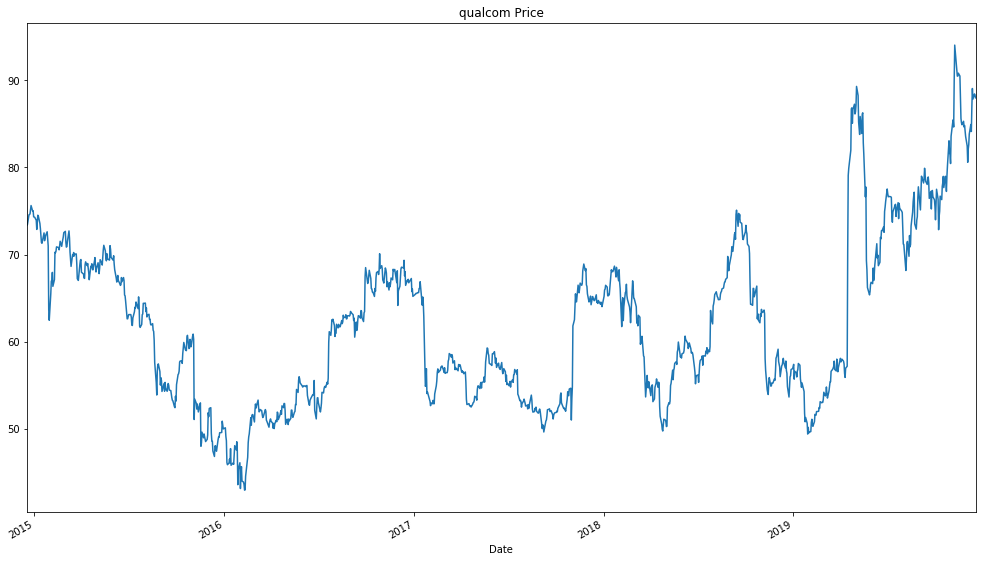

In [33]:
# Plot just the "Close/Last" column from the dataframe:
qualcom['Close'].plot(figsize=(17, 10), title="qualcom Price")

*Answer*
 * Based on the plot above, we can see a long-term strengthening of the qualcom prices. There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [34]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Close" price into two separate series:
qualcom_noise, qualcom_trend = sm.tsa.filters.hpfilter(qualcom['Close'])

In [35]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
qualcom_decomp = qualcom[["Close"]].copy()
qualcom_decomp["noise"] = qualcom_noise
qualcom_decomp["trend"] = qualcom_trend
qualcom_decomp.head()

,Close,noise,trend
Date,,,
2014-12-18,73.360001,-1.686686,75.046687
2014-12-19,73.430000,-1.513299,74.943299
2014-12-22,74.559998,-0.278860,74.838858
2014-12-23,74.599998,-0.131364,74.731362
2014-12-24,74.660004,0.041366,74.618638


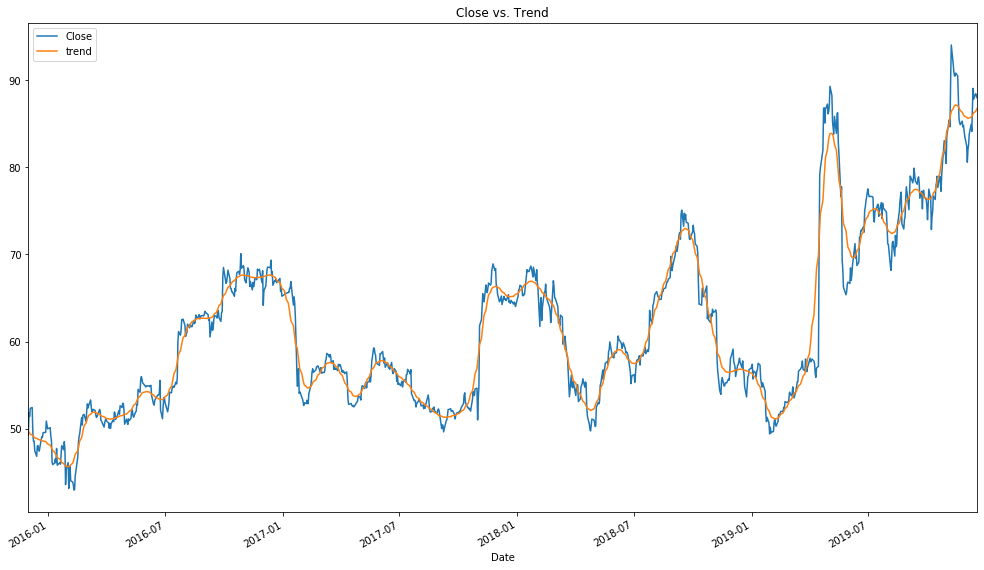

In [36]:
# Plot the Settle Price vs. the Trend
qualcom_decomp[["Close", "trend"]]["2015-12-01":].plot(figsize=(17, 10), title="Close vs. Trend")

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

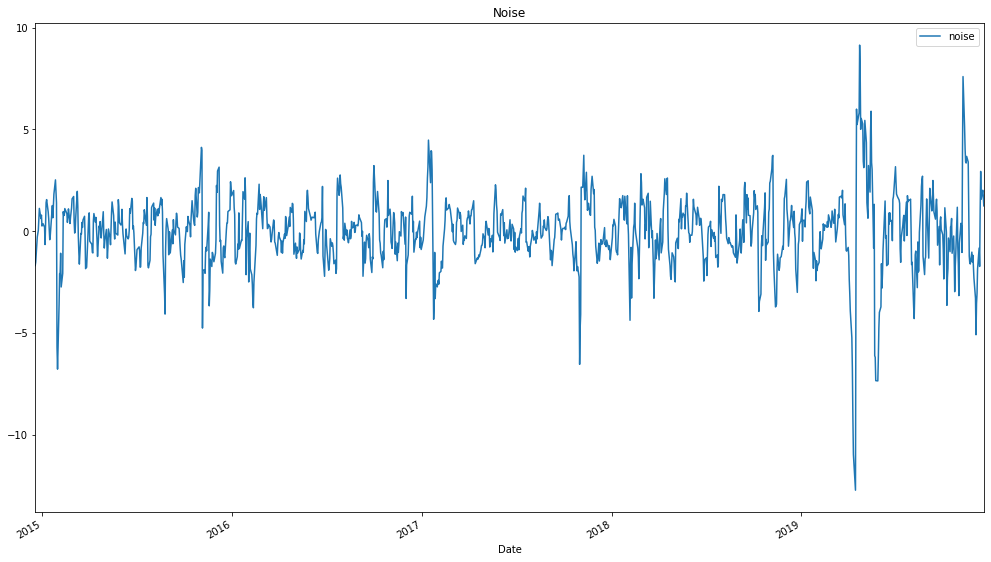

In [37]:
# Plot the Settle Noise
qualcom_decomp[["noise"]].plot(figsize=(17, 10), title="Noise")

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [38]:
# Create a series using "Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (qualcom[["Close"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Close
Date,
2019-12-12,2.368094
2019-12-13,-1.370018
2019-12-16,0.683136
2019-12-17,-0.124392
2019-12-18,-0.384960


In [39]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [40]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1258
Model:                     ARMA(2, 1)   Log Likelihood               -2644.234
Method:                       css-mle   S.D. of innovations              1.980
Date:                Fri, 20 Dec 2019   AIC                           5298.468
Time:                        22:26:10   BIC                           5324.154
Sample:                             0   HQIC                          5308.121
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0341      0.059      0.575      0.565      -0.082       0.150
ar.L1.y       -0.8688      0.045    -19.337      0.000      -0.957      -0.781
ar.L2.y        0.0424      0.029      1.450      0.147      -0.015       0.100
ma.L1.y        0.9402      0.035     27.034      0.000       0.872       1.008
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0928           +0.0000j            1.0928            0.5000
AR.2           21.6034           +0.0000j           21.6034            0.0000
MA.1           -1.0637           +0.0000j            1.0637            0.5000
-----------------------------------------------------------------------------
"""

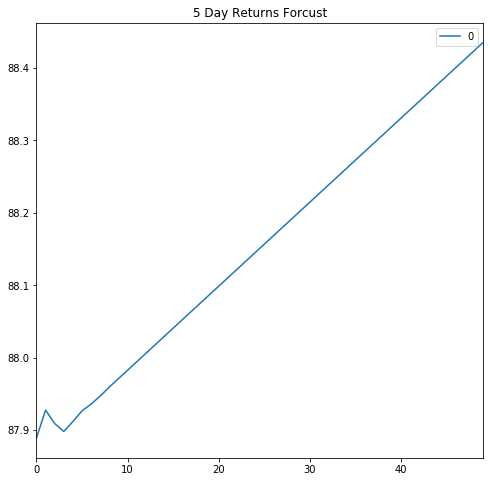

In [53]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=50)[0]).plot(figsize=(8, 8), title="5 Day Returns Forcust")

## Question:

#### Based on the p-value, is the model a good fit?

## Answer:

#### Based on the p-value, the model is not a good fit.

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [42]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(qualcom["Close"], order=(5, 1, 1))


# Fit the model
results = model.fit()

C:\Users\armen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\armen\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [43]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1258
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -2052.681
Method:                       css-mle   S.D. of innovations              1.237
Date:                Fri, 20 Dec 2019   AIC                           4121.362
Time:                        22:26:12   BIC                           4162.460
Sample:                             1   HQIC                          4136.807
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0116      0.041      0.283      0.778      -0.069       0.092
ar.L1.D.Close     0.2602      0.688      0.378      0.705      -1.089       1.609
ar.L2.D.Close    -0.0135      0.060     -0.224      0.823      -0.132       0.105
ar.L3.D.Close     0.0509      0.029      1.751      0.080      -0.006       0.108
ar.L4.D.Close     0.0355      0.046      0.778      0.437      -0.054       0.125
ar.L5.D.Close    -0.0278      0.039     -0.710      0.478      -0.105       0.049
ma.L1.D.Close    -0.1828      0.688     -0.266      0.791      -1.531       1.166
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1771           -0.0000j            2.1771           -0.5000
AR.2           -0.3073           -1.8763j            1.9013           -0.2758
AR.3           -0.3073           +1.8763j            1.9013            0.2758
AR.4            2.0343           -0.6598j            2.1386           -0.0499
AR.5            2.0343           +0.6598j            2.1386            0.0499
MA.1            5.4715           +0.0000j            5.4715            0.0000
-----------------------------------------------------------------------------
"""

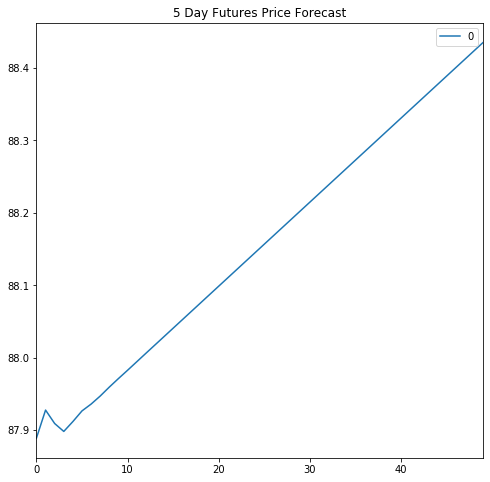

In [54]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=50)[0]).plot(figsize=(8, 8), title="5 Day Futures Price Forecast")

### What does the model forecast will happen to the Japanese Yen in the near term?

### Based on model forcast the Japanese Yen will go up in value

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [45]:
import arch as arch
from arch import arch_model

In [46]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1, rescale=False)

# Fit the model
res = model.fit(disp="off")

In [47]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2601.53
Distribution:                  Normal   AIC:                           5211.05
Method:            Maximum Likelihood   BIC:                           5231.60
                                        No. Observations:                 1258
Date:                Fri, Dec 20 2019   Df Residuals:                     1254
Time:                        22:26:12   Df Model:                            4
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          2.2294      0.692      3.220  1.283e-03    [  0.872,  3.587]
alpha[1]       0.0685  3.710e-02      1.846  6.495e-02 [-4.244e-03,  0.141]
alpha[2]       0.2618      0.288      0.909      0.363    [ -0.303,  0.826]
beta[1]        0.1723      0.214      0.804      0.421    [ -0.248,  0.592]
===========================================================================

Covariance estimator: robust
"""

In [48]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-12-18'

In [49]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [50]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.tail()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-12-18,26.35373,27.181793,30.357588,31.260115,32.224667


In [51]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-12-18
h.1,26.353730
h.2,27.181793
h.3,30.357588
h.4,31.260115
h.5,32.224667


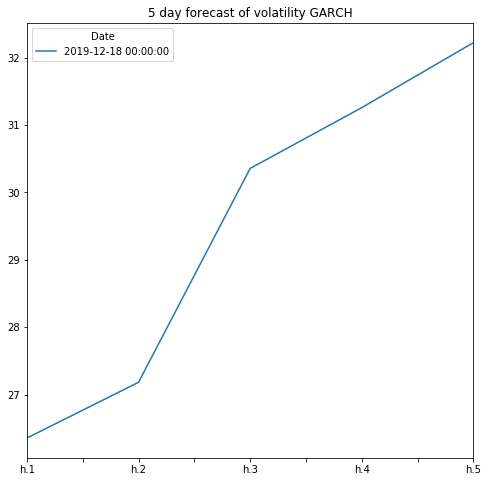

In [52]:
# Plot the final forecast
final.plot(figsize=(8, 8), title="5 day forecast of volatility GARCH")

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

2. Is the risk of the yen expected to increase or decrease?

3. Based on the model evaluation, would you feel confident in using these models for trading?

1. Based on time series analysis I would by the yen now.

2. Yes, the risk expected to increase.

3. Based on the model evaluation, I feel confident uding only GARCH model for trading. ARMA and ARIMA are not good fit.